In [195]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.stats
%matplotlib notebook

In [276]:
#quantum trajectories dephasing
omega = 2 * np.pi
dt = 1e-3
N_w = 1
N_steps = int(1e4)
Sz =  np.array([[1,0],[0,-1]])
Sx =  np.array([[0,1],[1,0]])
#define basis
base = np.array([[1,0],[0,1]])
a = 1 / np.sqrt(2)
b = 1 / np.sqrt(2)
psi0 = a * base[0] + b * base[1]

#define jump operators + gammas
F = np.array([[[0,1],[0,0]],[[0,0],[1,0]]],dtype = "complex")
gamma = np.array([1,0])
#initiate walkers
walkers = np.ones((N_w,2)) * psi0

S = gamma[:,None, None] * np.einsum('...ji,...jk->...ik',F.conj(),F, dtype="complex")

S_sum = np.sum(S,axis = 0)

H = omega * Sz + -1j * S_sum

U = scipy.linalg.expm(-1j * H * dt)
A = np.zeros(((np.size(F,axis=0)+1),np.size(F,axis = 1), np.size(F,axis = 2)),dtype="complex") #jump+unitary matrix set
A[0,:,:] = U
A[1:,:,:] = F

psi_avg = np.zeros((N_steps,np.size(psi0)),dtype = "complex")
x_spin = np.zeros((N_steps))
for i in range(0,N_steps):
    p_jump = np.einsum('hi,...ij,hj->h...' , walkers.conj(), S, walkers).real * dt
    p_sum = np.sum(p_jump,axis = 1)
    u = p_sum < np.random.rand(N_w)

    #for each jump take a random jump matrix
    p = np.zeros((N_w, np.size(F,axis=0)+1))
    p[:,1:]  = p_jump
    p[:,0] = 1 - p_sum #add extra column to p_jump with 1-p_sum
    
    x_k = np.arange(np.size(F,axis=0)+1)
    choice = np.zeros((N_w),dtype='int')
    for j in range(0, N_w):
        choice[j] = np.random.choice(x_k, 1 , p=p[j,:] )

    walkers = np.einsum('hij,hj -> hj',A[choice,:,:],walkers) 
    walkers /= np.linalg.norm(walkers,axis = 1, keepdims = True)
    psi_avg[i] = np.mean(walkers,axis = 0)
    x_spin[i] = np.einsum('i,ij,j',psi_avg[i].conj(), Sx, psi_avg[i]).real


<IPython.core.display.Javascript object>


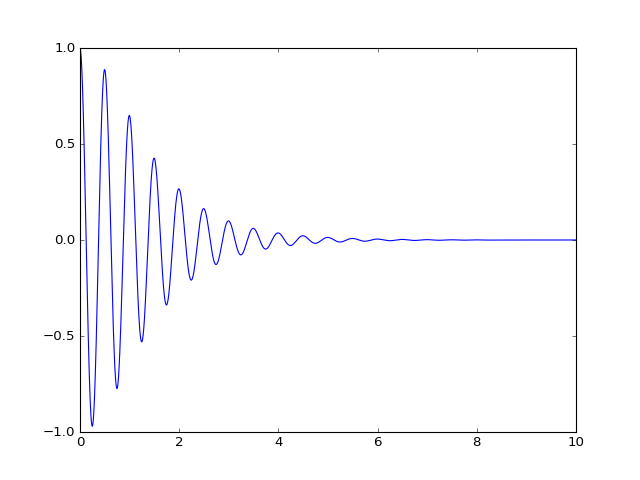

In [277]:
plt.plot(np.arange(len(x_spin))*dt,x_spin)

In [223]:
S

array([[[ 0.0+0.j,  0.0+0.j],
        [ 0.0+0.j,  0.1+0.j]],

       [[ 0.0+0.j,  0.0+0.j],
        [ 0.0+0.j,  0.0+0.j]]])

In [144]:
np.einsum('hi,...ij,hj->h...' , walkers.conj(), S, walkers).real * dt

array([[ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963],
       [ 0.0005015 ,  0.00024963]])

In [104]:
i = 1
np.einsum('ij,j',F[i,:,:] ,psi0)

array([ 0.00000000+0.j,  0.70710678+0.j])

In [109]:
u[:,None] * np.einsum('hij,hj -> hj',F[jump_i,:,:],walkers) 

array([[ 0.00000000+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.70710678+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.70710678+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j]])

In [108]:
F[jump_i,:,:]

array([[[ 0.+0.j,  1.+0.j],
        [ 0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j],
        [ 1.+0.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j],
        [ 0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j],
        [ 0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j],
        [ 1.+0.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j],
        [ 0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j],
        [ 1.+0.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j],
        [ 0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j],
        [ 1.+0.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j],
        [ 0.+0.j,  0.+0.j]]])